In [1]:
# Reference: https://github.com/statsmodels/statsmodels/blob/master/examples/notebooks/generic_mle.ipynb
%matplotlib inline
import numpy as np
import patsy
import pandas as pd
from scipy import stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import nbinom
from statsmodels.base.model import GenericLikelihoodModel
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error

In [8]:
data_file = '/scratch/sk7898/pedbike/1006_f_465_humans_490_bikes_13_feats.csv'
data  = pd.read_csv(data_file)
indices = np.arange(len(data))
train, test, train_indices, test_indices = train_test_split(data, indices, test_size=0.2, random_state=42)
train_1, val, train_indices, val_indices = train_test_split(train, train_indices, test_size=0.1, random_state=42)

print('Features: ', data.columns)
print('{} Train Indices: {}'.format(len(train_indices), train_indices))
print('{} Val Indices: {}'.format(len(val_indices), val_indices))
print('{} Test Indices: {}'.format(len(test_indices), test_indices))

Features:  Index(['th_2_numHitBins_max', 'th_2_numHitBins_median', 'th_6_moment_sum',
       'th_6_freqWidth', 'th_8_numHitBins_var', 'th_16_moment_sum',
       'th_42_moment_sum', 'th_46_maxFreq', 'th_62_numHitBins_median',
       'th_90_moment_sum', 'th_98_numHitBins_median', 'th_158_maxFreq',
       'th_198_maxFreq', 'Target', 'classLabel'],
      dtype='object')
687 Train Indices: [364 683 257 812 685 759 537 635 394 376 149 253 475 338 706 943 249 451
 206 339 488 244  52 171 930 460 630 690 461 566 401 272 153  82 277 439
 203 294 106 709 147 753 938 177 816 430 340 736 103 154 246 586 935 677
  27  16  57 155 263  73 681 545 788 599 519 116 922 910  46 583 796 261
 358 195 236  43 643  34 636  58 495 651 207 132 817 557 867 355 305 308
 559 887 776 164 163 794 108 863 175 546 688  19  28 569 289 184 924 457
  50 646 352 130 602   6 652 854 144 600 427 875 802 448 831 626 769 591
 479 570 563 862 901  97 489 178 637 738 271   0 432 196 226 560 804  12
 691 520  37  64 350 856 766

In [17]:
y_train, X_train = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=train)
y_test, X_test = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=test)
#X_train = preprocessing.normalize(X_train)
#X_test = preprocessing.normalize(X_test)

In [18]:
nb_results = sm.GLM(y_train.astype(int), X_train, family=sm.families.NegativeBinomial()).fit()
print(nb_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                  764
Model:                            GLM   Df Residuals:                      751
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1539.3
Date:                Thu, 05 Dec 2019   Deviance:                       76.429
Time:                        15:22:54   Pearson chi2:                     93.7
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [72]:
print(nb_results.model.exog_names)
print(nb_results.model.endog_names)

['Intercept', 'th_2_numHitBins_max', 'th_2_numHitBins_median', 'th_6_moment_sum', 'th_6_freqWidth', 'th_8_numHitBins_var', 'th_16_moment_sum', 'th_42_moment_sum', 'th_46_maxFreq', 'th_62_numHitBins_median', 'th_90_moment_sum', 'th_98_numHitBins_median', 'th_198_maxFreq']
Target


In [19]:
print_pred = False
y_pred_test = nb_results.predict(X_test)
y_pred_train = nb_results.predict(X_train)
if print_pred:
    for y_p, y_t in zip(y_pred_test.astype(np.int8), test.Target):
        print(y_p, y_t)
    
    for y_p, y_t in zip(y_pred_train.astype(np.int8), train.Target):
        print(y_p, y_t)

In [20]:
print(mean_absolute_error(y_train.astype(np.int8), y_pred_train.astype(np.int8)))
print(mean_absolute_error(test.Target, y_pred_test.astype(np.int8)))

0.612565445026178
0.5863874345549738


**Summary**

*Train Shape: (668, 13)*\
*Val Shape: (77, 13)
*Test Shape: (191, 13)*\
\
*Without normalization*
* Train MAE:0.6152694610778443
* Test MAE: 0.6097560975609756 

*With normalization*
* Train MAE: 0.6916167664670658
* Test MAE: 0.6724738675958188

*If all the samples were used for Train i.e. (955, 13)*
* MAE: 0.6083769633507854

In [91]:
nobs = nb_results.nobs
y = nb_results.model.endog/nb_results.model.endog.sum()
yhat = nb_results.mu

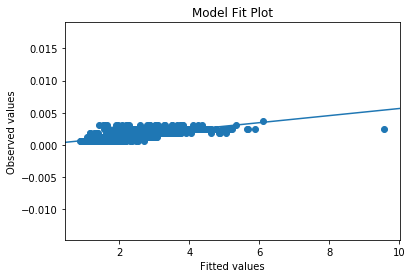

In [98]:
from statsmodels.graphics.api import abline_plot

fig, ax = plt.subplots()
ax.scatter(yhat, y)
line_fit = sm.OLS(y, sm.add_constant(yhat, prepend=True)).fit()
abline_plot(model_results=line_fit, ax=ax)


ax.set_title('Model Fit Plot')
ax.set_ylabel('Observed values')
ax.set_xlabel('Fitted values');

**Study with 2 Counters**

In [23]:
data_bike = data[data.classLabel == "Bike"]
data_ped = data[data.classLabel == "Human"]

train_bike, test_bike = train_test_split(data_bike, train_size=0.7, random_state=42)
y_bike_train, X_bike_train = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=train_bike)
y_bike_test, X_bike_test = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=test_bike)

train_ped, test_ped = train_test_split(data_ped, train_size=0.7, random_state=42)
y_ped_train, X_ped_train = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=train_ped)
y_ped_test, X_ped_test = patsy.dmatrices('Target ~ th_2_numHitBins_max + th_2_numHitBins_median + th_6_moment_sum + th_6_freqWidth + th_8_numHitBins_var + th_16_moment_sum + th_42_moment_sum + th_46_maxFreq + th_62_numHitBins_median + th_90_moment_sum + th_98_numHitBins_median + th_198_maxFreq', data=test_ped)

In [27]:
print(X_ped_train.shape)
print(X_ped_test.shape)

(325, 13)
(140, 13)


In [24]:
nb_bike = sm.GLM(y_bike_train.astype(int), X_bike_train, family=sm.families.NegativeBinomial()).fit()
y_pred_bike_train = nb_bike.predict(X_bike_train)
y_pred_bike_test = nb_bike.predict(X_bike_test)
print(mean_absolute_error(y_bike_train.astype(np.int8), y_pred_bike_train.astype(np.int8)))
print(mean_absolute_error(y_bike_test.astype(np.int8), y_pred_bike_test.astype(np.int8)))

0.5801749271137027
0.4965986394557823


In [25]:
nb_ped  = sm.GLM(y_ped_train.astype(int), X_ped_train, family=sm.families.NegativeBinomial()).fit()
y_pred_ped_train = nb_ped.predict(X_ped_train)
y_pred_ped_test = nb_ped.predict(X_ped_test)
print(mean_absolute_error(y_ped_train.astype(np.int8), y_pred_ped_train.astype(np.int8)))
print(mean_absolute_error(y_ped_test.astype(np.int8), y_pred_ped_test.astype(np.int8)))

0.5507692307692308
0.5928571428571429


**Summary**

**Human Counter**
* Train Shape: (325, 13)
* Test Shape: (140, 13)

* Train MAE:0.5507692307692308
* Test MAE: 0.5928571428571429 

**Bike Counter**
* Train Shape: (343, 13)
* Test Shape: (147, 13)
    
* Train MAE: 0.5801749271137027
* Test MAE: 0.4965986394557823